In [6]:
import json
import requests


class StorageClient:
    def __init__(self, endpoint, port, access_key, secret_key, secure=True, region=None):
        self.endpoint = endpoint
        self.port = port
        self.access_key = access_key
        self.secret_key = secret_key
        self.secure = secure
        self.region = region


class DataObject:
    def __init__(self, data_bucket_name, data_object_name, data_object_prefix_name=None, data_file_delimiter=','):
        self.data_bucket_name = data_bucket_name
        self.data_object_name = data_object_name
        self.data_object_prefix_name = data_object_prefix_name
        self.data_file_delimiter = data_file_delimiter


class ModelObject:
    def __init__(self, model_object_bucket_name, model_object_prefix_name=None, model_object_name=None):
        self.model_object_bucket_name = model_object_bucket_name
        self.model_object_prefix_name = model_object_prefix_name
        self.model_object_name = model_object_name

    def set_model_object_prefix_name(self, model_object_prefix_name):
        self.model_object_prefix_name = model_object_prefix_name

    def set_model_object_name(self, model_object_name):
        self.model_object_name = model_object_name


class OutputObject:
    def __init__(self, output_bucket_name, output_object_name=None, output_object_prefix_name=None,
                 output_file_delimiter=','):
        self.output_bucket_name = output_bucket_name
        self.output_object_name = output_object_name
        self.output_object_prefix_name = output_object_prefix_name
        self.output_file_delimiter = output_file_delimiter
        
    def set_output_object_prefix_name(self, output_object_prefix_name):
        self.output_object_prefix_name = output_object_prefix_name

    def set_output_object_name(self, output_object_name):
        self.output_object_name = output_object_name
        
    def set_output_file_delimiter(self, output_file_delimiter):
        self.output_file_delimiter = output_file_delimiter        
    

class RandomForestClassifier:
    def __init__(self, name='RandomForestClassifier', n_estimators=10, criterion="gini", max_depth=None, 
                 min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0., max_features="auto",
                 max_leaf_nodes=None, min_impurity_decrease=0., min_impurity_split=None,
                 bootstrap=True, oob_score=False, n_jobs=1, random_state=None,
                 verbose=0, warm_start=False, class_weight=None):
        self.name = name
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity_split = min_impurity_split
        self.bootstrap = bootstrap
        self.oob_score = oob_score
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.verbose = verbose
        self.warm_start = warm_start
        self.class_weight = class_weight


class KMeans:
    def __init__(self, n_clusters, name='KMeans', init='k-means++', precompute_distances='auto',
                 n_init=10, max_iter=300, verbose=0, tol=1e-4,
                 random_state=None, copy_x=True, n_jobs=1, algorithm="auto"):
        self.name = name
        self.n_clusters = n_clusters
        self.init = init
        self.precompute_distances = precompute_distances
        self.n_init = n_init
        self.max_iter = max_iter
        self.verbose = verbose
        self.tol = tol
        self.random_state = random_state
        self.copy_x = copy_x
        self.n_jobs = n_jobs
        self.algorithm = algorithm


class EstimatorClient:
    def __init__(self, endpoint, port, secure=False):
        self.endpoint = endpoint
        self.port = port
        if secure:
            self.protocol = 'https'
        else:
            self.protocol = 'http'

    def fit(self, estimator, storage_client, train_data_object, model_object, **kwargs):
        payload_dict = {**storage_client.__dict__, **train_data_object.__dict__, **model_object.__dict__,
                        'estimator_params': estimator.__dict__, **kwargs, 'lb_planner_endpoint': self.endpoint}
        
        if estimator.name == 'RandomForestClassifier':
            endpoint_url = self.protocol + '://' + self.endpoint + ':' + self.port + '/r/rfc-planner/train'
        elif estimator.name == 'KMeans':
            endpoint_url = self.protocol + '://' + self.endpoint + ':' + self.port + '/r/km-planner/train'

        response = requests.post(endpoint_url, json=payload_dict)

        body = json.loads(response.json())
        model_object.set_model_object_prefix_name(body['model_object_prefix_name'])
        model_object.set_model_object_name(body['model_object_name'])
        
        return model_object

    def predict(self, name, storage_client, predict_data_object, model_object, output_object):
        payload_dict = {**storage_client.__dict__, **predict_data_object.__dict__, **model_object.__dict__,
                        **output_object.__dict__, 'lb_planner_endpoint': self.endpoint}

        if name == 'RandomForestClassifier':
            endpoint_url = self.protocol + '://' + self.endpoint + ':' + self.port + '/r/rfc-planner/predict'
        elif name == 'KMeans':
            endpoint_url = self.protocol + '://' + self.endpoint + ':' + self.port + '/r/km-planner/predict'

        response = requests.post(endpoint_url, json=payload_dict)

        body = json.loads(response.json())
        output_object.set_output_object_prefix_name(body['output_object_prefix_name'])
        output_object.set_output_object_name(body['output_object_name'])
        output_object.set_output_file_delimiter(body['output_file_delimiter'])
        
        return output_object
    

In [7]:
from minio import Minio
from minio.error import ResponseError


def minio_init_client(endpoint, access_key=None, secret_key=None, secure=True,
                      region=None, http_client=None):
    client = Minio(endpoint, access_key, secret_key, secure, region, http_client)
    return client


def minio_get_object(client, bucketname, objectname, filepath):
    try:
        client.fget_object(bucketname, objectname, filepath)
    except ResponseError as err:
        print(err)

        
def minio_get_all_objects(client, bucketname, prefixname, local_file_prefix):
    try:
        objects = client.list_objects_v2(bucketname, prefix=prefixname, recursive=True)
        for obj in objects:
            minio_get_object(client, bucketname, obj.object_name,
                             local_file_prefix + '/' + obj.object_name.split('/')[-1])
    except ResponseError as err:
        print(err)

In [18]:
import time

t0 = time.time()
storage_client = StorageClient('129.158.84.105', 9000, 'JAHX7LAUXB7N6S208HCB',
                               'EuaJ2LZU0bdCztvSrGtUU4uN3DhgzMeXNOO2V2CH', False)
train_data_object = DataObject('higgs-data', 'higgs.train-data.csv')
model_object = ModelObject('higgs-model')

rfc = RandomForestClassifier(n_estimators=24, max_features='sqrt', max_depth=10, min_samples_leaf=1)
estimator_client = EstimatorClient('132.145.38.179', '8080', False)
model_object = estimator_client.fit(rfc, storage_client, train_data_object, model_object, n_outputs=1, aggregate_models=False)
print(model_object.model_object_bucket_name, model_object.model_object_prefix_name)
t1 = time.time()
print(t1-t0)

higgs-model 3fec09c6-d081-4bf7-bdd4-5a833d556663
240.3153533935547


In [19]:
import time

t0 = time.time()
storage_client = StorageClient('129.158.84.105', 9000, 'JAHX7LAUXB7N6S208HCB',
                               'EuaJ2LZU0bdCztvSrGtUU4uN3DhgzMeXNOO2V2CH', False)
predict_data_object = DataObject('higgs-data', 'higgs.test-data.csv')
# model_object = ModelObject('higgs-model', '')
output_object = OutputObject('higgs-output')

estimator_client = EstimatorClient('132.145.38.179', '8080', False)
output_object = estimator_client.predict('RandomForestClassifier', storage_client, predict_data_object, model_object, output_object)
print(output_object.output_bucket_name, output_object.output_object_prefix_name)
t1 = time.time()
print(t1-t0)

higgs-output 4c055ad7-9e6b-4e8f-ad61-9608cefd14e4
235.8395712375641


In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

minio_client = minio_init_client(storage_client.endpoint + ':' + str(storage_client.port), storage_client.access_key,
                 storage_client.secret_key, storage_client.secure, storage_client.region)
minio_get_object(minio_client, output_object.output_bucket_name, 
                 output_object.output_object_prefix_name + '/final/final_predictions.csv',
                'output/predictions.csv')

original_labels = np.array(pd.read_csv('higgs_data/higgs.test-data-y.csv', header=None))
predicted_labels = np.array(pd.read_csv('output/predictions.csv', header=None))

print('Test Accuracy: ', accuracy_score(original_labels, predicted_labels) * 100, '%')
print('Confusion Matrix', '\n', confusion_matrix(original_labels, predicted_labels))

Test Accuracy:  70.90385454545455 %
Confusion Matrix 
 [[318270 166371]
 [133683 412926]]


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


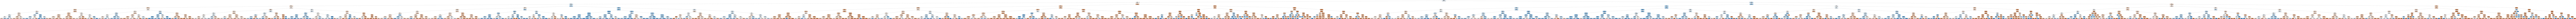

In [11]:
from sklearn.externals import joblib
from sklearn.tree import export_graphviz

minio_client = minio_init_client(storage_client.endpoint + ':' + str(storage_client.port), storage_client.access_key,
                 storage_client.secret_key, storage_client.secure, storage_client.region)
minio_get_all_objects(minio_client, model_object.model_object_bucket_name, 
                      model_object.model_object_prefix_name, 'model')

model = joblib.load('model/model_0_0.pkl')
estimator = model.estimators_[0]
export_graphviz(estimator, out_file='tree.dot', 
#                 feature_names = iris.feature_names,
#                 class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')